# 필수과제 1 : VGG-11 implementation and fine-tuning


필수과제 1번에서는 VGG-11 model을 구현해보고, QuickDraw dataset에 대해 직접 구현한 모델을 완전히 random 한 weight에서 시작하는(training from scratch) 학습을 해보게 됩니다. 또, torchvision에 내장된 VGG-11의 pretrained weight를 불러와 적절한 수정을 통해 feature extractor 부분은 고정하고, classification을 수행하는 부분만 새로 학습하는 fine-tuning을 시도하며 training from scratch와의 차이점을 비교하게 됩니다.

과제 목표
- Pre-trained 네트워크를 활용 할 수 있다.
- Fine-tuning을 위해 네트워크의 일부를 고정하고 다른 일부만 학습할 수 있다.
- 네트워크를 일부 커스터마이즈해서 다른 문제에 적용할 수 있는 응용 능력을 갖춘다.


## Quickdraw dataset
Quickdraw dataset은 다양한 물체에 대한 간단한 sketch로 구성된 데이터셋입니다. [데이터셋 홈페이지](https://quickdraw.withgoogle.com/data)에서 예시 이미지들을 확인할 수 있으니, 데이터셋에 어떤 이미지들이 있는지 확인해보시기 바랍니다. 

이번 과제에서는 model을 보다 쉽게 구현할 수 있도록 데이터를 불러오는 과정에서 모든 이미지들을 VGG-11의 기본 input size인 (224 x 224)로 변경해줍니다. 또, 전체 class가 아닌 10개의 class만을 사용해 학습을 진행하게 됩니다.

아래 가려진 코드들은 필요한 패키지들을 import하고, QuickDraw dataset을 사용하기 위한 준비 코드들입니다. 코드가 꽤 길어 가려두었으며, 과제를 수행하기 위해 이해가 필수적인 코드는 아니지만 해당 과정을 이해하고 싶다면 코드를 확인해보셔도 좋습니다.


In [ ]:
# install quickdraw python API
!pip3 install quickdraw

In [ ]:
# import packages
from quickdraw import QuickDrawData, QuickDrawDataGroup
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import itertools
import matplotlib.pyplot as plt
import os
import numpy as np
import torch.nn as nn
import pandas as pd

In [ ]:
# fix random seeds
import random
random.seed(100)
torch.manual_seed(0)

In [ ]:
num_img_per_class = 3000
qd = QuickDrawData(max_drawings=num_img_per_class)

In [ ]:
class_list = ['apple', 'wine bottle', 'spoon', 'rainbow', 'panda', 'hospital', 'scissors', 'toothpaste', 'baseball', 'hourglass']
class_dict = {'apple' : 0, 'wine bottle' : 1, 'spoon' : 2, 'rainbow' : 3, 'panda': 4, 'hospital' : 5, 'scissors' : 6, 'toothpaste' : 7, 'baseball' : 8, 'hourglass' : 9}

In [ ]:
qd.load_drawings(class_list)

downloading apple from https://storage.googleapis.com/quickdraw_dataset/full/binary/apple.bin
download complete
loading apple drawings
load complete
downloading wine bottle from https://storage.googleapis.com/quickdraw_dataset/full/binary/wine bottle.bin
download complete
loading wine bottle drawings
load complete
downloading spoon from https://storage.googleapis.com/quickdraw_dataset/full/binary/spoon.bin
download complete
loading spoon drawings
load complete
downloading rainbow from https://storage.googleapis.com/quickdraw_dataset/full/binary/rainbow.bin
download complete
loading rainbow drawings
load complete
downloading panda from https://storage.googleapis.com/quickdraw_dataset/full/binary/panda.bin
download complete
loading panda drawings
load complete
downloading hospital from https://storage.googleapis.com/quickdraw_dataset/full/binary/hospital.bin
download complete
loading hospital drawings
load complete
downloading scissors from https://storage.googleapis.com/quickdraw_datase

In [ ]:
# get images, and append to train/validation data and label list
train_data = list()
val_data = list()
train_label = list()
val_label = list()
for class_name in class_list:
  qdgroup = QuickDrawDataGroup(class_name, max_drawings=num_img_per_class)
  for i, img in enumerate(qdgroup.drawings):
    if i < int(0.9 * num_img_per_class):
      train_data.append(np.asarray(img.get_image()))
      train_label.append(class_dict[class_name])
    else:
      val_data.append(np.asarray(img.get_image()))
      val_label.append(class_dict[class_name])

loading apple drawings
load complete
loading wine bottle drawings
load complete
loading spoon drawings
load complete
loading rainbow drawings
load complete
loading panda drawings
load complete
loading hospital drawings
load complete
loading scissors drawings
load complete
loading toothpaste drawings
load complete
loading baseball drawings
load complete
loading hourglass drawings
load complete


In [ ]:
# transformation, image to (224, 224) tensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
])

In [ ]:
# custom dataset for Quickdraw
class QuickDrawDataset(Dataset):

    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]
        label = self.labels[idx]
        if self.transform:
          img = self.transform(img)
        return img, label

In [ ]:
# quickdraw train/validatoin dataset and dataloader
qd_train_dataset = QuickDrawDataset(train_data, train_label, transform)
qd_val_dataset = QuickDrawDataset(val_data, val_label, transform)

qd_train_dataloader = DataLoader(qd_train_dataset, batch_size=64, shuffle=True)
qd_val_dataloader = DataLoader(qd_val_dataset, batch_size=64, shuffle=True)

In [ ]:
# Misc

class AverageMeter(object):
  """Computes and stores the average and current value"""
  def __init__(self):
      self.reset()

  def reset(self):
    self.val = 0
    self.avg = 0
    self.sum = 0
    self.count = 0

  def update(self, val, n=1):
    self.val = val
    self.sum += val * n
    self.count += n
    self.avg = self.sum / self.count

## Custom VGG-11 implementation

아래 Table은 여러 종류의 VGG 네트워크에 대한 각각의 구성을 나타낸 것입니다.
<br>A에서 E까지 다양한 크기의 VGG 중에서 구현하고자 하는 네트워크는 **A에 해당하는 VGG-11**입니다.

----

<img src='https://drive.google.com/uc?id=1bFKnmwcbdJLQdCjNPxQdaYnTNCmBt0rK'  width="700">

아래 코드는 VGG-11 네트워크를 나타내는 class입니다. 위 figure를 참고해서 코드의 TODO 부분을 채워주세요. 필요한 경우, [VGG-11 original paper](https://arxiv.org/pdf/1409.1556.pdf)를 참고하셔도 좋습니다.

- **TO DO (1-1)** : Feature extractor 역할을 수행하는 convolution layers를 구현하는 것이 과제입니다. 주어진 ```self.conv1, self.bn, self.pool1```코드와 위 표를 참고하여 나머지 부분을 채워주세요.

- **TO DO (1-2)** : Convolution filter로 이루어진 feature extractor에서 얻은 이미지에 대한 feature를 통해 classification task를 수행하는 fully connected layer를 구현하고자 합니다. Convolution layer의 output dimension을 고려해, convolution layer에서 extract된 feature들이 Quickdraw의 **10개 class**에 해당하는 output으로 잘 연결될 수 있도록 fully connected layer의 일부를 채워주세요. 

- TO DO (1-2)의 힌트로, forward 함수의 feature extraction이 끝나고 FC layer가 시작하는 부분의 output tensor shape를 확인할 수 있는 코드를 작성해두었습니다. Model의 feed forward를 수행하는 과정에서 해당 부분의 tensor shape가 출력되므로, 이 정보를 이용해 fully connected layer의 input dimension을 계산 할 수 있습니다. 이처럼, 모델을 만드는 과정에서 복잡한 기술 없이 간단한 print()문 하나만으로도 큰 도움을 얻을 수 있다는 점을 기억하고 있으시면 큰 도움이 될 것이라 생각합니다. VGG 모델을 모두 구현하고 나서는 forward 과정에서 원치 않는 tensor shape의 출력을 방지하기 위해 해당 부분 코드를 주석처리 하거나 삭제하시면 됩니다.

In [ ]:
import torch
import torch.nn as nn

class VGG11(nn.Module):
  def __init__(self, num_classes=10):
    super(VGG11, self).__init__()

    self.relu = nn.ReLU(inplace=True)
    
    # Convolution Feature Extraction Part
    self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
    self.bn1   = nn.BatchNorm2d(64)
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

    # TO DO (1-1) starts here!
    # Fill empty parts with proper code
    self.conv2 = #FILL HERE#
    self.bn2   = #FILL HERE#
    self.pool2 = #FILL HERE#

    self.conv3_1 = #FILL HERE#
    self.bn3_1   = #FILL HERE#
    self.conv3_2 = #FILL HERE#
    self.bn3_2   = #FILL HERE#
    self.pool3   = #FILL HERE#

    self.conv4_1 = #FILL HERE#
    self.bn4_1   = #FILL HERE#
    self.conv4_2 = #FILL HERE#
    self.bn4_2   = #FILL HERE#
    self.pool4   = #FILL HERE#

    self.conv5_1 = #FILL HERE#
    self.bn5_1   = #FILL HERE#
    self.conv5_2 = #FILL HERE#
    self.bn5_2   = #FILL HERE#
    self.pool5   = #FILL HERE#
    # TO DO (1-1) ends here!

    # Fully Connected Classifier Part
    # TO DO (1-2) starts here!
    # Fill empty parts with proper code
    self.fc1      = #FILL HERE#
    self.dropout1 = nn.Dropout()
    self.fc2      = #FILL HERE#
    self.dropout2 = nn.Dropout()
    
    self.fc3      = 
    # TO DO (1-2) ends here!

  def forward(self, x):
    # Convolution Feature Extraction Part
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.pool1(x)

    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu(x)
    x = self.pool2(x)

    x = self.conv3_1(x)
    x = self.bn3_1(x)
    x = self.relu(x)
    x = self.conv3_2(x)
    x = self.bn3_2(x)
    x = self.relu(x)
    x = self.pool3(x)

    x = self.conv4_1(x)
    x = self.bn4_1(x)
    x = self.relu(x)
    x = self.conv4_2(x)
    x = self.bn4_2(x)
    x = self.relu(x)
    x = self.pool4(x)

    x = self.conv5_1(x)
    x = self.bn5_1(x)
    x = self.relu(x)
    x = self.conv5_2(x)
    x = self.bn5_2(x)
    x = self.relu(x)
    x = self.pool5(x)

    # part to help debugging by checking tensor size
    # delete or comment out this line after debugging
    print(f'Tensor shape after convolution layers is {x.shape}')

    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = self.relu(x)
    x = self.dropout1(x)
    
    x = self.fc2(x)
    x = self.relu(x)
    x = self.dropout2(x)
    
    x = self.fc3(x)
    return x

----
구현한 VGG-11에 문제가 없다면 네트워크의 **output tensor는 10-dim vector**에 해당해야 합니다. 

<br>아래의 코드를 실행하여 **output tensor의 shape을 확인**해봅시다.
<br> 만약 ```out = model_test(x)```를 실행하였을 때 오류가 발생한다면 layer 구현에 오류가 있는 것이니 다시 한번 네트워크 코드에 문제가 없는지 확인해보세요 :)


아래의 문구와 동일하게 출력된다면 output tensor의 shape이 알맞게 return된 것입니다!
```python
"Output tensor shape is : torch.Size([1, 10])"
```

In [ ]:
# Network
model_test = VGG11(num_classes=10)

# Random input
x = torch.randn((1, 3, 224, 224))

# Forward
out = model_test(x)

# Check the output shape
print("Output tensor shape is :", out.shape)

Output tensor shape is : torch.Size([1, 10])


## Training custom VGG-11 from scratch
이제 직접 구현한 VGG-11을 학습시켜보겠습니다. 모델을 학습하기 위해,
1. DataLoader에서 image, label을 불러오고
2. model에 image를 foward한 이후 output logit과 label의 loss를 계산하고
3. loss를 통해 optimizer의 backward를 수행해 parameter를 업데이트하는

일반적인 학습 loop을 완성하게 됩니다.

해당 과정에서 과제로 작성해야하는 부분은 아래와 같습니다.

- **TO DO (2-1)** : VGG-11을 본격적으로 학습하는 과정입니다. 주석에 적힌 내용을 따라 loss function인 ```criterion```과 ```optimizer```를 활용하여 빈 부분을 채워주세요.

- **TO DO (2-2)** : 학습된 VGG-11을 validation dataset에 대해 평가하는 과정입니다. Validation 과정에서는 <U>gradient 계산과 backpropagation이 필요 없다</U>는 것에 주목하여 빈 부분을 채워주세요.

- **TO DO (2-3)** : 빠른 학습을 위해서는 GPU 사용이 필수적입니다. GPU에서 학습하기 위해 필요한 것들(모델이나 텐서 등)을 .cuda()명령어를 이용해 적절히 GPU로 옮겨 학습할 수 있게 해주세요.

TO DO (2-3)는 다양한 구현 방법이 있을 수 있기 때문에, *starts here, ends here* 주석이 없습니다. 본인이 생각하기에 적절한 위치나, 빈칸으로 남아있는 부분에 구현해주세요.

In [ ]:
# Build user-defined VGG model
model_scratch = VGG11(num_classes=10)

VGG11(
  (relu): ReLU(inplace=True)
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3_1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3_2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4_1): Conv2d(256, 51

In [ ]:
# Loss function and Optimizer
from torch.optim import Adam

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model_scratch.parameters(), lr=1e-4)

In [ ]:
log_dir ='./log'

In [ ]:
# Main
os.makedirs(log_dir, exist_ok=True)

with open(os.path.join(log_dir, 'scratch_train_log.csv'), 'w') as log:
  # Training
  # TO DO (2-1) starts here!
  # Fill empty parts with proper code

  # set model to train mode
  model_scratch.#FILL HERE#
  for iter, (img, label) in enumerate(qd_train_dataloader):

    # optimizer에 저장된 미분값을 0으로 초기화
    optimizer.#FILL HERE#

    # 학습에 사용하기 위한 image, label 처리 (필요한 경우, data type도 변경해주세요)
    img, label = #FILL HERE#
  
    # 모델에 이미지 forward
    pred_logit = #FILL HERE#

    # loss 값 계산
    loss = #FILL HERE#

    # Backpropagation
    loss.#FILL HERE#
    optimizer.#FILL HERE#
    # TO DO (2-1) ends here!

    # Accuracy 계산
    pred_label = torch.argmax(pred_logit, 1)
    acc = (pred_label == label).sum().item() / len(img)

    train_loss = loss.item()
    train_acc = acc

    # Validation 
    if (iter % 20 == 0) or (iter == len(qd_train_dataloader)-1):
      # TO DO (2-2) starts here!
      # Fill empty parts with proper code

      # set model to validation mode
      model_scratch.#FILL HERE#
      valid_loss, valid_acc = AverageMeter(), AverageMeter()

      for img, label in qd_val_dataloader:
        # Validation에 사용하기 위한 image, label 처리 (필요한 경우, data type도 변경해주세요)
        img, label = #FILL HERE#

        # 모델에 이미지 forward (gradient 계산 X)
        with #FILL HERE#:
          pred_logit = #FILL HERE#

        # loss 값 계산
        loss = #FILL HERE#

        # TO DO (2-2) ends here!

        # Accuracy 계산
        pred_label = torch.argmax(pred_logit, 1)
        acc = (pred_label == label).sum().item() / len(img)

        valid_loss.update(loss.item(), len(img))
        valid_acc.update(acc, len(img))

      valid_loss = valid_loss.avg
      valid_acc = valid_acc.avg

      print("Iter [%3d/%3d] | Train Loss %.4f | Train Acc %.4f | Valid Loss %.4f | Valid Acc %.4f" %
            (iter, len(qd_train_dataloader), train_loss, train_acc, valid_loss, valid_acc))
      
      # Train Log Writing
      log.write('%d,%.4f,%.4f,%.4f,%.4f\n'%(iter, train_loss, train_acc, valid_loss, valid_acc))

Iter [  0/422] | Train Loss 2.3614 | Train Acc 0.0781 | Valid Loss 2.3027 | Valid Acc 0.1000
Iter [ 20/422] | Train Loss 2.2882 | Train Acc 0.1250 | Valid Loss 2.2854 | Valid Acc 0.0997
Iter [ 40/422] | Train Loss 1.9107 | Train Acc 0.3750 | Valid Loss 1.7363 | Valid Acc 0.4547
Iter [ 60/422] | Train Loss 1.3807 | Train Acc 0.6094 | Valid Loss 1.2329 | Valid Acc 0.6180
Iter [ 80/422] | Train Loss 0.9763 | Train Acc 0.7031 | Valid Loss 1.0202 | Valid Acc 0.6730
Iter [100/422] | Train Loss 0.9859 | Train Acc 0.6875 | Valid Loss 0.8945 | Valid Acc 0.7143
Iter [120/422] | Train Loss 0.9871 | Train Acc 0.7812 | Valid Loss 0.7212 | Valid Acc 0.7853
Iter [140/422] | Train Loss 0.7171 | Train Acc 0.7344 | Valid Loss 0.6883 | Valid Acc 0.7883
Iter [160/422] | Train Loss 0.6598 | Train Acc 0.7656 | Valid Loss 0.6842 | Valid Acc 0.7887
Iter [180/422] | Train Loss 0.3118 | Train Acc 0.8750 | Valid Loss 0.5818 | Valid Acc 0.8320
Iter [200/422] | Train Loss 0.6049 | Train Acc 0.8281 | Valid Loss 0.5

## Fine-tuning VGG-11 with pretrained feature extractor
이번에는 torchvision에서 제공하는 pretrained VGG-11을 이용한 fine-tuning 학습을 진행하게 됩니다. Fine-tuning의 경우도 기본적인 training 방법은 동일하지만, 이번에는 모든 parameter를 처음부터 학습하는 대신 **feature extractor는 기존 학습된 상태에서 고정하고 linear classifier만 새로 학습**한다는 차이가 있습니다. 

Fine tuning을 위해 작성해야하는 코드는 아래와 같습니다.

- **TO DO (3-1, 3-2, 3-3)** : Training from scratch의 1~3과 같이, 모델이 잘 학습될 수 있도록 빈 부분을 채워주세요. 마찬가지로, validation을 수행할 때는 gradient 계산 및 backpropagation이 필요 없음을 주목하고, 필요한 경우 model이나 tensor등을 .cuda()를 사용해 적절히 GPU로 옮겨주세요

- **TO DO (3-4)** : Torchvision에서 제공하는 VGG-11의 경우는 1000개의 class에 대한 classification을 수행하는 모델입니다. 따라서, Quickdraw dataset에 사용하기 위해서는 마지막 linear layer가 1000-dim vector 대신 10-dim vector를 내보내야 합니다. 이를 위해 마지막 *nn.Linear* layer를 수정해주세요.

- **TO DO (3-5)** : Linear classifier만을 학습하기 위해, convolution layers들의 weight를 freeze 해주세요.

- Hint : Google에 *how to freeze conv layers* 를 검색한 [결과](https://www.google.com/search?q=how+to+freeze+conv+layers&oq=how+to+&aqs=chrome.0.69i59j69i57j0i512l3j69i60l3.809j0j7&sourceid=chrome&ie=UTF-8) 나오는 [stackoverflow 글](https://discuss.pytorch.org/t/how-the-pytorch-freeze-network-in-some-layers-only-the-rest-of-the-training/7088)을 참고하면 쉽게 구현할 수 있습니다. 이와 같이, 필요한 내용을 잘 googling하는 실력은 앞으로의 개발 과정에서도 필수적인 능력이 될 것입니다. 앞으로를 위해 **정확한 키워드로 잘 검색하는 습관**을 들이시면 모든 함수를 외우지 않고도 효율적이고 빠른 코딩이 가능할 것입니다.

In [ ]:
from torchvision.models import vgg11

pretrained = True 
model_finetune = vgg11(pretrained)

# TO DO (3-4, 3-5) starts here
# Fill empty parts with proper code

# change VGG-11's output dimension to 10
model_finetune.classifier[6] = #FILL HERE#

# Freeze the feature extracting convolution layers
# FILL HERE #

## TO DO (3-4, 3-5) ends here

Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth


  0%|          | 0.00/507M [00:00<?, ?B/s]

In [ ]:
# Loss function and Optimizer
from torch.optim import Adam

criterion = nn.CrossEntropyLoss()
optimizer_ft = Adam(model_finetune.parameters(), lr=1e-4)

In [ ]:
# Main
os.makedirs(log_dir, exist_ok=True)

with open(os.path.join(log_dir, 'scratch_train_log.csv'), 'w') as log:
  # Training
  # TO DO (3-1) starts here!
  # Fill empty parts with proper code

  # set model to train mode
  model_finetune.#FILL HERE#
  for iter, (img, label) in enumerate(qd_train_dataloader):

    # optimizer에 저장된 미분값을 0으로 초기화
    optimizer.#FILL HERE#

    # 학습에 사용하기 위한 image, label 처리 (필요한 경우, data type도 변경해주세요)
    img, label = #FILL HERE#
  
    # 모델에 이미지 forward
    pred_logit = #FILL HERE#

    # loss 값 계산
    loss = #FILL HERE#

    # Backpropagation
    loss.#FILL HERE#
    optimizer.#FILL HERE#
    # TO DO (3-1) ends here!

    # Accuracy 계산
    pred_label = torch.argmax(pred_logit, 1)
    acc = (pred_label == label).sum().item() / len(img)

    train_loss = loss.item()
    train_acc = acc

    # Validation 
    if (iter % 20 == 0) or (iter == len(qd_train_dataloader)-1):
      # TO DO (3-2) starts here!
      # Fill empty parts with proper code

      # set model to validation mode
      model_finetune.#FILL HERE#
      valid_loss, valid_acc = AverageMeter(), AverageMeter()

      for img, label in qd_val_dataloader:
        # Validation에 사용하기 위한 image, label 처리 (필요한 경우, data type도 변경해주세요)
        img, label = #FILL HERE#

        # 모델에 이미지 forward (gradient 계산 X)
        with #FILL HERE#:
          pred_logit = #FILL HERE#

        # loss 값 계산
        loss = #FILL HERE#

        # TO DO (3-2) ends here!

        # Accuracy 계산
        pred_label = torch.argmax(pred_logit, 1)
        acc = (pred_label == label).sum().item() / len(img)

        valid_loss.update(loss.item(), len(img))
        valid_acc.update(acc, len(img))

      valid_loss = valid_loss.avg
      valid_acc = valid_acc.avg

      print("Iter [%3d/%3d] | Train Loss %.4f | Train Acc %.4f | Valid Loss %.4f | Valid Acc %.4f" %
            (iter, len(qd_train_dataloader), train_loss, train_acc, valid_loss, valid_acc))
      
      # Train Log Writing
      log.write('%d,%.4f,%.4f,%.4f,%.4f\n'%(iter, train_loss, train_acc, valid_loss, valid_acc))

Iter [  0/422] | Train Loss 2.3833 | Train Acc 0.0781 | Valid Loss 2.1864 | Valid Acc 0.2253
Iter [ 20/422] | Train Loss 0.7159 | Train Acc 0.7031 | Valid Loss 0.6243 | Valid Acc 0.7940
Iter [ 40/422] | Train Loss 0.3609 | Train Acc 0.8750 | Valid Loss 0.4101 | Valid Acc 0.8763
Iter [ 60/422] | Train Loss 0.4569 | Train Acc 0.9219 | Valid Loss 0.3720 | Valid Acc 0.8890
Iter [ 80/422] | Train Loss 0.3292 | Train Acc 0.9219 | Valid Loss 0.3520 | Valid Acc 0.8977
Iter [100/422] | Train Loss 0.3179 | Train Acc 0.8906 | Valid Loss 0.3383 | Valid Acc 0.8957
Iter [120/422] | Train Loss 0.1949 | Train Acc 0.9688 | Valid Loss 0.2924 | Valid Acc 0.9163
Iter [140/422] | Train Loss 0.2820 | Train Acc 0.9375 | Valid Loss 0.2872 | Valid Acc 0.9137
Iter [160/422] | Train Loss 0.4325 | Train Acc 0.8594 | Valid Loss 0.3081 | Valid Acc 0.9110
Iter [180/422] | Train Loss 0.2026 | Train Acc 0.9219 | Valid Loss 0.2784 | Valid Acc 0.9177
Iter [200/422] | Train Loss 0.1920 | Train Acc 0.9375 | Valid Loss 0.2

## Visualizing training results
아래 코드는 training from scratch와 fine tuning의 학습 경향을 비교할 수 있는 그래프를 출력해주는 코드입니다. 수렴 속도, accuracy 등 학습 결과에서 확인할 수 있는 정보들을 통해 from scratch, fine tuning중 어떤 방법이 더 우수한지, 또 그 이유는 무엇인지 자유롭게 생각해보고 캠퍼분들과 논의해보세요!

In [ ]:
# Load log file
scratch_train_log = pd.read_csv(os.path.join(log_dir, 'scratch_train_log.csv'), index_col=0, header=None)
fine_tuned_train_log = pd.read_csv(os.path.join(log_dir, 'fine_tuned_train_log.csv'), index_col=0, header=None)

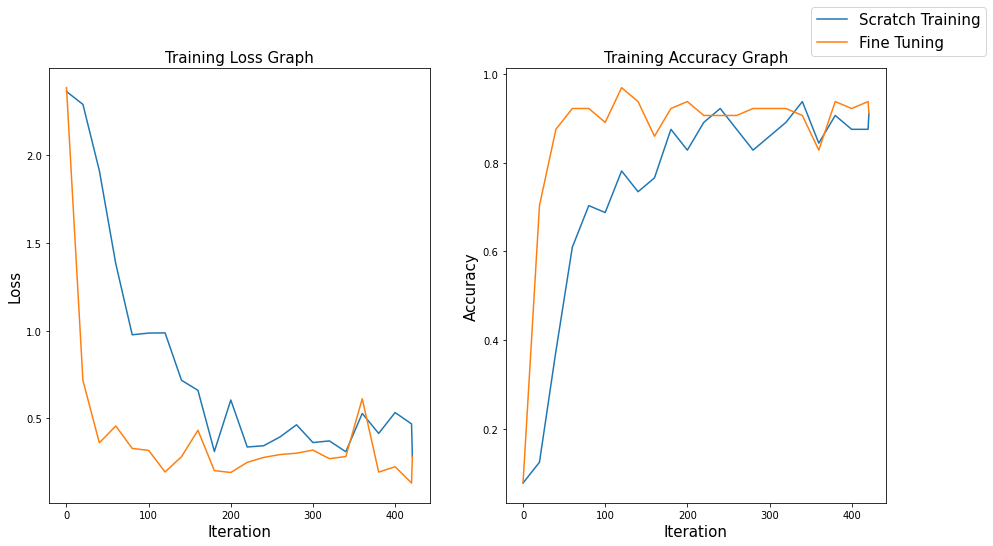

In [ ]:
# Visualize training log
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))

ax1.plot(scratch_train_log.iloc[:,0], label='Scratch Training')
ax1.plot(fine_tuned_train_log.iloc[:,0], label='Fine Tuning')
ax1.set_title('Training Loss Graph', fontsize=15)
ax1.set_xlabel('Iteration', fontsize=15)
ax1.set_ylabel('Loss', fontsize=15)

fig.legend(fontsize=15)

ax2.plot(scratch_train_log.iloc[:,1], label='Scratch Training')
ax2.plot(fine_tuned_train_log.iloc[:,1], label='Fine Tuning')
ax2.set_title('Training Accuracy Graph', fontsize=15)
ax2.set_xlabel('Iteration', fontsize=15)
ax2.set_ylabel('Accuracy', fontsize=15)

plt.show()

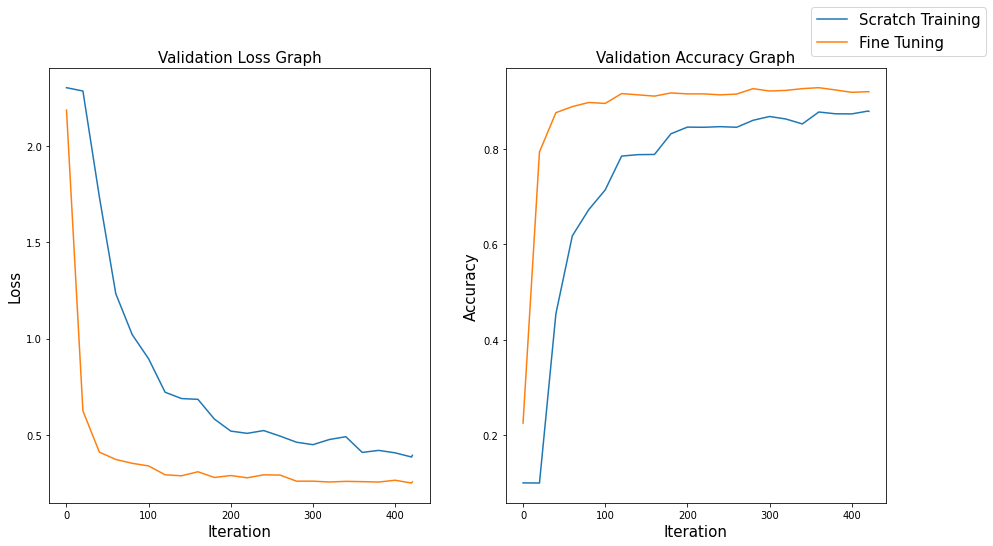

In [ ]:
# Visualize validation log
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))

ax1.plot(scratch_train_log.iloc[:,2], label='Scratch Training')
ax1.plot(fine_tuned_train_log.iloc[:,2], label='Fine Tuning')
ax1.set_title('Validation Loss Graph', fontsize=15)
ax1.set_xlabel('Iteration', fontsize=15)
ax1.set_ylabel('Loss', fontsize=15)

fig.legend(fontsize=15)

ax2.plot(scratch_train_log.iloc[:,3], label='Scratch Training')
ax2.plot(fine_tuned_train_log.iloc[:,3], label='Fine Tuning')
ax2.set_title('Validation Accuracy Graph', fontsize=15)
ax2.set_xlabel('Iteration', fontsize=15)
ax2.set_ylabel('Accuracy', fontsize=15)

plt.show()